# Load: part-of-speech-olive-cormorant

In [ ]:
import pickle
import pandas as pd

from tqdm.auto import tqdm

In [ ]:
model_name = "part-of-speech-olive-cormorant"

In [ ]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [ ]:
len(train_data), len(test_data)

In [ ]:
def _to_list_of_lists(data):
    res = []
    for example in tqdm(data):
        cur_res = ([], [])
        cur_word, cur_tag = [], set()
        for token, tag in zip(*example):
            if tag == '[MASK]':
                continue
            cur_word.append(token)
            cur_tag = cur_tag.union(set(tag.split('+')))
            if '[WORD_END]' in cur_tag:
                cur_tag = sorted(filter(lambda x: not x == '[WORD_END]', list(cur_tag)))
                cur_res[0].append(cur_word)
                cur_res[1].append('+'.join(cur_tag))
                cur_word, cur_tag = [], set()
        res.append(cur_res)
    return res

In [ ]:
train_data = _to_list_of_lists(train_data)
test_data = _to_list_of_lists(test_data)

In [ ]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

In [ ]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

In [ ]:
len(list(test_words - train_words))

In [ ]:
test_word_lens = pd.Series([len(word) for word in test_words])

In [ ]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Load: part-of-speech-intersyllabic-olive-cormorant

In [1]:
import pickle
import pandas as pd

In [2]:
model_name = "part-of-speech-intersyllabic-olive-cormorant"

In [4]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [5]:
len([t for w, _ in train_data for t in w]), len([t for w, _ in test_data for t in w])

(248509, 27717)

In [6]:
train_data[0]

([[558, 246],
  [2394, 88],
  [912, 137],
  [471, 57, 289],
  [117],
  [583, 212, 1828, 644],
  [1613, 52, 3225],
  [1029],
  [6680],
  [362, 9878],
  [9955]],
 ['NOUN+PART',
  'NOUN+ADP',
  'NOUN+ADP',
  'NOUN',
  'ADP',
  'NOUN',
  'ADJ+ADP',
  'NOUN',
  'unk',
  'NOUN',
  'PUNCT'])

In [7]:
len(train_data), len(test_data)

(28186, 3110)

In [8]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

20634

In [9]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

5578

In [10]:
len(set(test_words - train_words))

1255

In [11]:
len(set(train_words - test_words))

16311

In [12]:
train_word_lens = pd.Series([len(word) for word in train_words])

<AxesSubplot:>

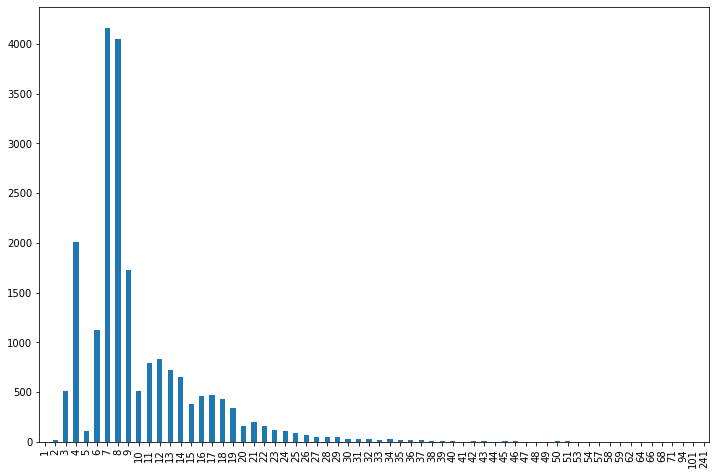

In [13]:
train_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

In [14]:
test_word_lens = pd.Series([len(word) for word in test_words])

<AxesSubplot:>

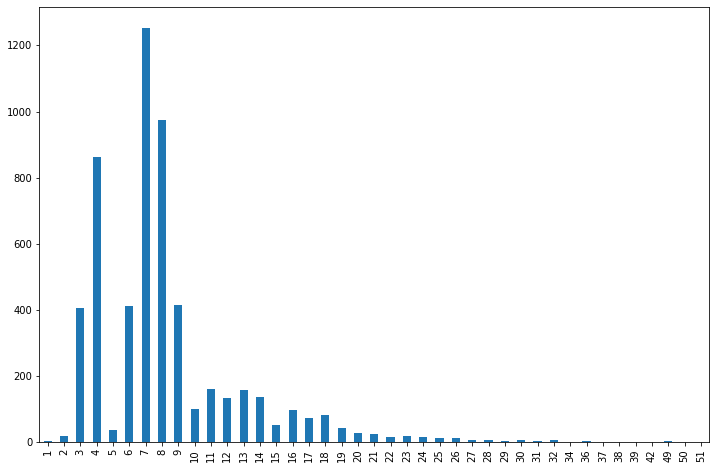

In [15]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Classification metrics on new words

In [16]:
from tqdm.auto import tqdm

In [17]:
from cai_manas.part_of_speech.pos_tagger import PartOfSpeechTagger

In [18]:
from sklearn.metrics import precision_recall_fscore_support

In [19]:
tagger = PartOfSpeechTagger(model_name)

In [20]:
res_tokens, res_tags, res_labels = [], [], []
for datum in tqdm(test_data):
    if len(datum[0]) == 0:
        continue
    try:
        cur_tags = tagger.predict_tokens([token for word in datum[0] for token in word])
    except:
        print(datum)
        raise Exception()
    cur_tags = [tagger.id_to_label_map[pred] for pred in cur_tags[1:-1]]
    res_tokens.append(datum[0])
    res_tags.append(cur_tags)
    seq_labels = []
    for word, word_label in zip(datum[0], datum[1]):
        seq_labels.append(word_label)
        for _ in range(len(word) - 1):
            seq_labels.append('[MASK]')
    res_labels.append(seq_labels)

  0%|          | 0/3110 [00:00<?, ?it/s]

In [21]:
label2id = {
    label.upper(): id_
    for id_, label in tagger.id_to_label_map.items()
}

## Out-of-vocabulary

In [22]:
strange_tags, strange_labels = [], []
# for test_word in tqdm(list(test_words.intersection(train_words))):
for test_word in tqdm(list(test_words - train_words)):
    test_tokens = list(map(int, test_word.split(' ')))
    for example, tags, labels in zip(res_tokens, res_tags, res_labels):
        example_str = [' '.join(map(str, word)) for word in example]
        if test_word in example_str:
            word_idx = example.index(test_tokens)
            tag_idx = sum([len(word) for word in example[:word_idx]])
            strange_tags.extend(tags[tag_idx:tag_idx+len(example[word_idx])])
            strange_labels.extend(labels[tag_idx:tag_idx+len(example[word_idx])])

  0%|          | 0/1255 [00:00<?, ?it/s]

In [23]:
strange_tags = [label2id[t.upper()] for t in strange_tags]
strange_labels = [label2id.get(l.upper(), label2id['UNK']) for l in strange_labels]

In [24]:
precision, recall, f1, support = precision_recall_fscore_support(
    strange_labels,
    strange_tags,
    labels=range(max(0, min(label2id.values())), max(label2id.values()) + 1),
    zero_division=0
)

In [25]:
res_df = {
    "tag": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "Support": []
}
for tag, tag_precision, tag_recall, tag_f1, tag_support in zip(
    [tagger.id_to_label_map.get(i, 'WTF') for i in range(len(f1))], precision, recall, f1, support
):
    res_df["tag"].append(tag)
    res_df["Precision"].append(tag_precision)
    res_df["Recall"].append(tag_recall)
    res_df["F1"].append(tag_f1)
    res_df["Support"].append(tag_support)
res_df = pd.DataFrame(res_df).set_index('tag').sort_values("Support", ascending=False)

mask_res_df = res_df
non_mask_res_df = res_df[res_df.index != '[MASK]']

mask_res_df["Support"] = mask_res_df.Support / mask_res_df.Support.sum()
print(mask_res_df[mask_res_df.index == '[MASK]'])

non_mask_res_df["Support"] = non_mask_res_df.Support / non_mask_res_df.Support.sum()
print(non_mask_res_df.head(10))
res_df = non_mask_res_df

        Precision    Recall       F1   Support
tag                                           
[MASK]    0.96531  0.895155  0.92891  0.662283
            Precision    Recall        F1   Support
tag                                                
NOUN         0.610256  0.856115  0.712575  0.433022
PROPN        0.717949  0.396226  0.510638  0.165109
NOUN+ADP     0.758824  0.791411  0.774775  0.126947
NOUN+PART    0.743243  0.774648  0.758621  0.055296
unk          0.586207  0.492754  0.535433  0.053738
VERB         0.577320  0.811594  0.674699  0.053738
ADJ          0.354839  0.468085  0.403670  0.036604
PROPN+ADP    0.703704  0.463415  0.558824  0.031931
PROPN+PART   0.000000  0.000000  0.000000  0.010903
ADJ+ADP      0.500000  0.571429  0.533333  0.005452


/tmp/ipykernel_295460/2681762738.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mask_res_df["Support"] = non_mask_res_df.Support / non_mask_res_df.Support.sum()


In [26]:
totals_df = res_df.copy()
print("Support percentage:", totals_df.Support.sum() / res_df.Support.sum())
totals_df["Support"] = totals_df.Support / totals_df.Support.sum()
print("Weighted average precision:", (totals_df.Precision * totals_df.Support).sum())
print("Weighted average recall:", (totals_df.Recall * totals_df.Support).sum())
print("Weighted average f1:", (totals_df.F1 * totals_df.Support).sum())

Support percentage: 1.0
Weighted average precision: 0.6272128477314887
Weighted average recall: 0.690809968847352
Weighted average f1: 0.6395884844927584


## In-vocabulary

In [27]:
in_univ_tags = [label2id[t.upper()] for ex in res_tags for t in ex]
in_univ_labels = [label2id.get(l.upper(), label2id['UNK']) for ex in res_labels for l in ex]

In [28]:
precision, recall, f1, support = precision_recall_fscore_support(
    in_univ_labels,
    in_univ_tags,
    labels=range(max(0, min(label2id.values())), max(label2id.values()) + 1),
    zero_division=0
)

In [29]:
res_df = {
    "tag": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "Support": []
}
for tag, tag_precision, tag_recall, tag_f1, tag_support in zip(
    [tagger.id_to_label_map.get(i, 'WTF') for i in range(len(f1))], precision, recall, f1, support
):
    res_df["tag"].append(tag)
    res_df["Precision"].append(tag_precision)
    res_df["Recall"].append(tag_recall)
    res_df["F1"].append(tag_f1)
    res_df["Support"].append(tag_support)
res_df = pd.DataFrame(res_df).set_index('tag').sort_values("Support", ascending=False)

mask_res_df = res_df
non_mask_res_df = res_df[res_df.index != '[MASK]']

mask_res_df["Support"] = mask_res_df.Support / mask_res_df.Support.sum()
print(mask_res_df[mask_res_df.index == '[MASK]'])

non_mask_res_df["Support"] = non_mask_res_df.Support / non_mask_res_df.Support.sum()
print(non_mask_res_df.head(10))
res_df = non_mask_res_df

        Precision    Recall        F1   Support
tag                                            
[MASK]   0.960803  0.973013  0.966869  0.315021
           Precision    Recall        F1   Support
tag                                               
NOUN        0.913466  0.944428  0.928689  0.248007
PART        0.975617  0.973075  0.974344  0.124617
ADP         0.977511  0.990634  0.984029  0.115561
PUNCT       1.000000  0.992926  0.996450  0.112206
VERB        0.954745  0.936713  0.945643  0.108886
CCONJ       0.990698  0.992236  0.991466  0.046470
NOUN+ADP    0.929448  0.946875  0.938080  0.046181
NOUN+PART   0.919903  0.938119  0.928922  0.029152
unk         0.864706  0.703349  0.775726  0.022621
DET         0.995114  0.988673  0.991883  0.022297


/tmp/ipykernel_295460/2681762738.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mask_res_df["Support"] = non_mask_res_df.Support / non_mask_res_df.Support.sum()


In [30]:
totals_df = res_df.copy()
print("Support percentage:", totals_df.Support.sum() / res_df.Support.sum())
totals_df["Support"] = totals_df.Support / totals_df.Support.sum()
print("Weighted average precision:", (totals_df.Precision * totals_df.Support).sum())
print("Weighted average recall:", (totals_df.Recall * totals_df.Support).sum())
print("Weighted average f1:", (totals_df.F1 * totals_df.Support).sum())

Support percentage: 1.0
Weighted average precision: 0.9447035557794519
Weighted average recall: 0.941299563444817
Weighted average f1: 0.940990025152403
